In [15]:
# import libraries 
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
import sys
import re

# Set some options for printing all the columns
np.set_printoptions(precision = 10, threshold = sys.maxsize)
np.set_printoptions(linewidth = np.inf)

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.options.display.float_format = '{:,.10f}'.format

# Load the dataset
mydata = pd.read_csv('Top Movies (Cleaned Data)_New2.csv', encoding='ISO-8859-1')
df = pd.DataFrame(mydata)

In [16]:
# entropy filter
def calculate_metadata(df):
    """
    Calculated for each feature in the DataFrame:
      - Data Type
      - Number and percentage of missing values
      - Number of unique values
      - String type or not (simple judgment)
      - Entropy
      - Percent of Entropy
      - Mean
      - Coefficient of Variation
    """
    nRow, nCol = df.shape
    features = df.columns
    result_list = []

    for thisVar in features:
        thisDType = df[thisVar].dtypes
        nNaN = df[thisVar].isna().sum()
        percentNaN = 100.0 * (nNaN / nRow)
        isString = np.nan
        entropy = np.nan
        percentEntropy = np.nan
        mean_ = np.nan
        coefVar = np.nan
        uniqueValue = df[thisVar].value_counts(dropna=False)
        nValid = uniqueValue.sum()
        nUnique = uniqueValue.size  
        if nUnique > 0:
            isString = 0
            if isinstance(uniqueValue.index.tolist()[0], str):
                isString = 1
            uniqueProp = uniqueValue / nValid
            entropy = -np.sum(uniqueProp * np.log2(uniqueProp + 1e-12))
            if nUnique > 1:
                e0 = 0.0 
                e1 = np.log2(nUnique)
                percentEntropy = 100.0 * (entropy / e1) if e1 > 0 else np.nan
            if (isString == 0) and (thisDType in [np.float64, np.int64]):
                mean_ = np.mean(df[thisVar].dropna())
                std_ = np.std(df[thisVar].dropna(), ddof=1)
                if abs(mean_) < 1e-12:
                    coefVar = np.nan
                else:
                    coefVar = std_ / abs(mean_)
        result_list.append([
            thisVar, 
            thisDType, 
            isString, 
            nValid, 
            nNaN, 
            percentNaN, 
            nUnique, 
            entropy, 
            percentEntropy, 
            mean_, 
            coefVar
        ])

    metaData = pd.DataFrame(result_list, columns=[
        'Feature Field', 
        'DType', 
        'String Value?', 
        'Number of Valids', 
        'Number of NaNs', 
        'Percent of NaNs', 
        'Number of Unique Values', 
        'Entropy', 
        'Percent of Entropy', 
        'Mean', 
        'Coefficient of Variation'
    ])

    return metaData

def feature_selection(metaData, 
                      max_missing=50.0, 
                      min_entropy=30.0,
                      min_cv=0.2):
    """
    Filter features according to the following rules:
      1. delete if Percent of NaNs > max_missing;
      2. delete if Percent of Entropy < min_entropy;
      3. delete if DType is numeric and Coefficient of Variation < min_cv;
    Returns: subset of retained feature metaData
    """
    def keep_field(row):
        if row["Percent of NaNs"] > max_missing:
            return False
        if not pd.isna(row["Percent of Entropy"]) and row["Percent of Entropy"] < min_entropy:
            return False
        if row["DType"] in [np.float64, np.int64]:
            cv = row["Coefficient of Variation"]
            if not pd.isna(cv) and abs(cv) < min_cv:
                return False
        return True

    filtered = metaData[metaData.apply(keep_field, axis=1)]
    return filtered

In [17]:
# Compute metadata statistics
metaData = calculate_metadata(df)

# Filtering based on customized thresholds
final_features_meta = feature_selection(
    metaData,
    max_missing=50.0,   # Features with >50% miss rate removed
    min_entropy=30.0,   # Features with less than 30% entropy share removed
    min_cv=0.2          # Numerical features CV < 0.2 are removed
)
kept_fields = final_features_meta["Feature Field"].tolist()
df = df[kept_fields].copy()
final_features_meta.head()

,Feature Field,DType,String Value?,Number of Valids,Number of NaNs,Percent of NaNs,Number of Unique Values,Entropy,Percent of Entropy,Mean,Coefficient of Variation
0,id,object,1,6569,0,0.0000000000,6569,12.6814580407,99.9999999253,NaN,NaN
1,Movie Name,object,1,6569,0,0.0000000000,6463,12.6487255778,99.9268232971,NaN,NaN
2,Release Date,object,0,6569,107,1.6288628406,3277,11.2943663288,96.7135779079,NaN,NaN
3,Production Budget (USD),int64,0,6569,0,0.0000000000,569,7.1343234074,77.9512824429,"33,019,121.4725224525",1.3651422317
4,Domestic Gross (USD),int64,0,6569,0,0.0000000000,5780,11.6098973794,92.9025624065,"42,497,640.0622621402",1.7210543787


In [25]:
# Date Columns Cleaning: 
# Convert “Release Date” and “Video Release” to datetime type; extract year, month, day of week, etc.
date_columns = ["Release Date", "Video Release"]
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"Converted column '{col}' to datetime.")
        

df["Release_Year"] = df["Release Date"].dt.year
df["Release_Month"] = df["Release Date"].dt.month
df["Release_DayOfWeek"] = df["Release Date"].dt.dayofweek  # 0=周一，6=周日
df["Release Date"] = pd.to_datetime(df["Release Date"], errors="coerce")
df["Video Release"] = pd.to_datetime(df["Video Release"], errors="coerce")
df = df.dropna(subset=["Release Date"])


# Calculate the number of days between video releases 
# Handle possible negative values (in case of data issues, such as future release dates)
df["Video Release Delay (days)"] = (df["Video Release"] - df["Release Date"]).dt.days
df["Video Release Delay (days)"] = df["Video Release Delay (days)"].clip(lower=0)

# Calculate the median 'Video Release Delay (days)' for every 10 years
df["Decade"] = (df["Release_Year"] // 10) * 10  # e.g. 1995 → 1990, 2012 → 2010
median_delay_by_decade = df.groupby("Decade")["Video Release Delay (days)"].median()

# Impute Video Release Delay (days)
def fill_video_release_delay(row):
    if pd.isna(row["Video Release Delay (days)"]):
        return median_delay_by_decade.get(row["Decade"], np.nan) 
    return row["Video Release Delay (days)"]
df["Video Release Delay (days)"] = df.apply(fill_video_release_delay, axis=1)
df.loc[df["Video Release"].isna(), "Video Release"] = (
    df["Release Date"] + pd.to_timedelta(df["Video Release Delay (days)"], unit="D")
)
df.drop(columns=["Decade"], inplace=True)

# ------------------------------------------------------------------------------------------------------------------------
# Financial Columns Cleaning:
# If Domestic Gross equals Worldwide Gross, set International Box Office to 0 and set Worldwide Box Office to the value of Domestic Box Office
mask_equal = df["Domestic Gross (USD)"] == df["Worldwide Gross (USD)"]
df.loc[mask_equal, "International Box Office (USD)"] = 0
df.loc[mask_equal, "Worldwide Box Office (USD)"] = df.loc[mask_equal, "Domestic Box Office (USD)"]

# Condition 2: If Domestic Share Percentage is 100%, it means the domestic box office share is 100%.
mask_domestic = df["Domestic Share Percentage"] == 100
df.loc[mask_domestic, "International Box Office (USD)"] = 0
df.loc[mask_domestic, "Worldwide Box Office (USD)"] = df.loc[mask_domestic, "Domestic Box Office (USD)"]
columns_to_check = ["Domestic Box Office (USD)", "Domestic Share Percentage", "Worldwide Box Office (USD)"]
df_missing = df[df[columns_to_check].isna().any(axis=1)]

# Loop through missing value rows
for idx, row in df_missing.iterrows():
    
    # If Domestic Gross is 0, it means the movie had no domestic revenue
    if row["Domestic Gross (USD)"] == 0:
        # Set Domestic Box Office to 0
        df.at[idx, "Domestic Box Office (USD)"] = 0
        # Set Domestic Share Percentage to 0
        df.at[idx, "Domestic Share Percentage"] = 0
        
        # Handling Worldwide Box Office:
        # - If Worldwide Gross is 0, set Worldwide Box Office to 0.
        # - Otherwise, since there is no domestic revenue, the Worldwide Box Office
        #   consists entirely of the International Box Office, so we use Worldwide Gross.
        if row["Worldwide Gross (USD)"] == 0:
            df.at[idx, "Worldwide Box Office (USD)"] = 0
        else:
            df.at[idx, "Worldwide Box Office (USD)"] = row["Worldwide Gross (USD)"]
    
    else:
        # If Domestic Gross is NOT 0 (rare cases), apply the following rules:

        # Fill missing Domestic Box Office with Domestic Gross
        if pd.isna(row["Domestic Box Office (USD)"]):
            df.at[idx, "Domestic Box Office (USD)"] = row["Domestic Gross (USD)"]
        
        # Fill missing Worldwide Box Office with Worldwide Gross
        if pd.isna(row["Worldwide Box Office (USD)"]):
            df.at[idx, "Worldwide Box Office (USD)"] = row["Worldwide Gross (USD)"]
        
        # Assume 100% Domestic Share since only Domestic Gross exists
        df.at[idx, "Domestic Share Percentage"] = 100

# Remove rows where `Worldwide Box Office (USD)` is still 0
df = df[df["Worldwide Box Office (USD)"] != 0]

# ------------------------------------------------------------------------------------------------------------------------
# Financial ratios Engineering:
# 1) Production budget to global box office ratio (note treatment of division by zero)
df["Budget_to_WorldGross_Ratio"] = df["Production Budget (USD)"] / df["Worldwide Gross (USD)"].replace({0: np.nan})
df["Budget_to_WorldGross_Ratio"].fillna(0, inplace=True)  
print("Created feature 'Budget_to_WorldGross_Ratio'.")

df["Domestic_vs_International_Ratio"] = df["Domestic Gross (USD)"] / df["International Box Office (USD)"].replace({0: np.nan})
df["Domestic_vs_International_Ratio"].fillna(0, inplace=True)
print("Created feature 'Domestic_vs_International_Ratio'.")

financial_cols = ["Production Budget (USD)", "Domestic Gross (USD)", "Worldwide Gross (USD)"]
for col in financial_cols:
    if col in df.columns:
        df[col + "_log"] = np.log1p(df[col])
        print(f"Log transformation was performed on {col} and a new variable {col+'_log'} was generated.")


# ------------------------------------------------------------------------------------------------------------------------
# Categorical Columns Engineering:
df['Creative Type'] = df['Creative Type'].str.strip().str.title()
df['Creative Type'] = df['Creative Type'].replace({'\tScience Fiction': 'Science Fiction'})
df['Genre'] = df['Genre'].str.strip().str.title()
df['Genre'] = df['Genre'].replace({'\tAction': 'Action'})

# Feature extraction
df["Theater counts"] = df["Theater counts"].astype(str)
def extract_theater_info(row):
    match = re.search(r"([\d,]+) opening theaters/([\d,]+) max\. theaters, ([\d.]+) weeks", row)
    if match:
        opening_theaters = int(match.group(1).replace(",", ""))
        max_theaters = int(match.group(2).replace(",", ""))
        weeks_run = float(match.group(3))
        return pd.Series([opening_theaters, max_theaters, weeks_run])
    return pd.Series([np.nan, np.nan, np.nan])

df[["Opening Theaters", "Max Theaters", "Weeks Run"]] = df["Theater counts"].apply(extract_theater_info)
df["Decade"] = (df["Release_Year"] // 10) * 10

# Calculation of the median for each decade
median_by_decade = df.groupby("Decade")[["Opening Theaters", "Max Theaters", "Weeks Run"]].median()
median_by_decade = median_by_decade.fillna(method="bfill")  # backfilling

def fill_missing_values(row):
    decade = row["Decade"]
    for col in ["Opening Theaters", "Max Theaters", "Weeks Run"]:
        if pd.isna(row[col]): 
            row[col] = median_by_decade.at[decade, col] if decade in median_by_decade.index else np.nan
    return row

df = df.apply(fill_missing_values, axis=1)
df.drop(columns=["Decade"], inplace=True)


# MPAA Cleaning
df = df.dropna(subset=['MPAA Rating'])
valid_ratings = ["G", "PG", "PG-13", "R", "NC-17", "Not Rated", "NR", "Unrated"]
df["MPAA Rating Cleaned"] = df["MPAA Rating"].str.extract(f"({'|'.join(valid_ratings)})", flags=re.IGNORECASE)
df["MPAA Rating Cleaned"] = df["MPAA Rating Cleaned"].str.upper().replace({
    "NR": "Not Rated",
    "UNRATED": "Not Rated"
})
df["MPAA Rating"] = df["MPAA Rating Cleaned"]
df.drop(columns=["MPAA Rating Cleaned"], inplace=True)

#Source Cleaning
df["Source Cleaned"] = df["Source"].str.strip()
df["Source Cleaned"] = df["Source Cleaned"].str.title()
df["Source Cleaned"] = df["Source Cleaned"].replace({
    "\tBased On Tv": "Based On Tv",
    "Based On Factual Book/Article": "Based On Book",
    "Based On Fiction Book/Short Story": "Based On Book",
    "Based On Comic/Graphic Novel": "Based On Book",
    "Based On Poem": "Based On Book",
    "Based On Musical Or Opera": "Based On Performance Art",
    "Based On Ballet": "Based On Performance Art",
})
df["Source"] = df["Source Cleaned"]
df.drop(columns=["Source Cleaned"], inplace=True)  # 删除临时列
df = df.dropna(subset=["Source"])

#Genre Cleaning
df["Genre Cleaned"] = df["Genre"].str.strip()
df["Genre Cleaned"] = df["Genre Cleaned"].replace({
    "Thriller/Suspense": "Thriller",  
    "Black Comedy": "Comedy",        
    "Romantic Comedy": "Comedy",      
    "Concert/Performance": "Musical", 
    "Reality": "Documentary",      
})
df = df[df["Genre Cleaned"] != "Multiple Genres"]
df["Genre"] = df["Genre Cleaned"]
df.drop(columns=["Genre Cleaned"], inplace=True)
df = df.dropna(subset=["Genre"])

Converted column 'Release Date' to datetime.
Converted column 'Video Release' to datetime.
Created feature 'Budget_to_WorldGross_Ratio'.
Created feature 'Domestic_vs_International_Ratio'.
Log transformation was performed on Production Budget (USD) and a new variable Production Budget (USD)_log was generated.
Log transformation was performed on Domestic Gross (USD) and a new variable Domestic Gross (USD)_log was generated.
Log transformation was performed on Worldwide Gross (USD) and a new variable Worldwide Gross (USD)_log was generated.


In [26]:
df.shape

(6018, 36)

In [29]:
# Not using product.financing company too much distinct; 
# Not using keywords for NLP, 
# Not using production country as too many distinct values 
# No need domestic release date，
# Can't deal with the data for opening weekend
# Infl. Adj. Dom. BO (USD) can be inferred

In [28]:
df.to_csv("Movie Final Data.csv", index=False)

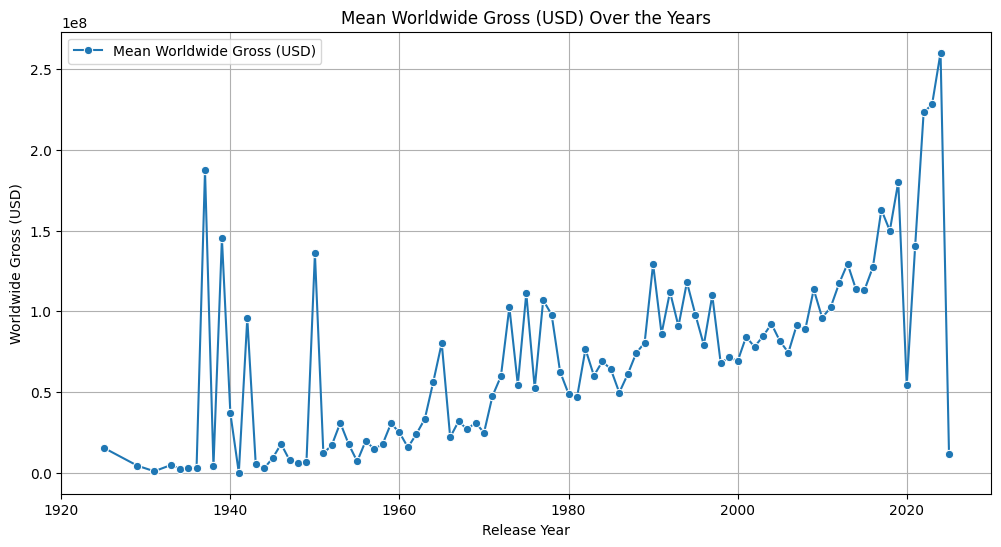

In [31]:
#EDA

df_grouped = df.groupby("Release_Year")["Worldwide Gross (USD)"].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=df_grouped.index, y=df_grouped.values, marker="o", label="Mean Worldwide Gross (USD)")
plt.xlabel("Release Year")
plt.ylabel("Worldwide Gross (USD)")
plt.title("Mean Worldwide Gross (USD) Over the Years")
plt.grid(True)
plt.legend()
plt.show()


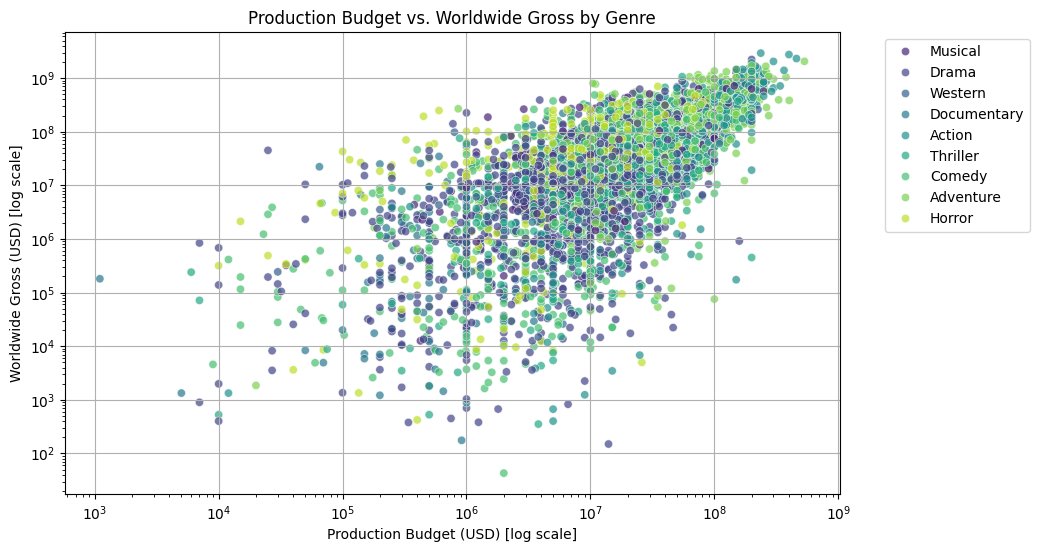

In [33]:
# -------------------------------
# Production Budget vs. Worldwide Gross
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df, 
    x="Production Budget (USD)", 
    y="Worldwide Gross (USD)", 
    hue="Genre", 
    alpha=0.7, 
    palette="viridis"
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Production Budget (USD) [log scale]")
plt.ylabel("Worldwide Gross (USD) [log scale]")
plt.title("Production Budget vs. Worldwide Gross by Genre")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()

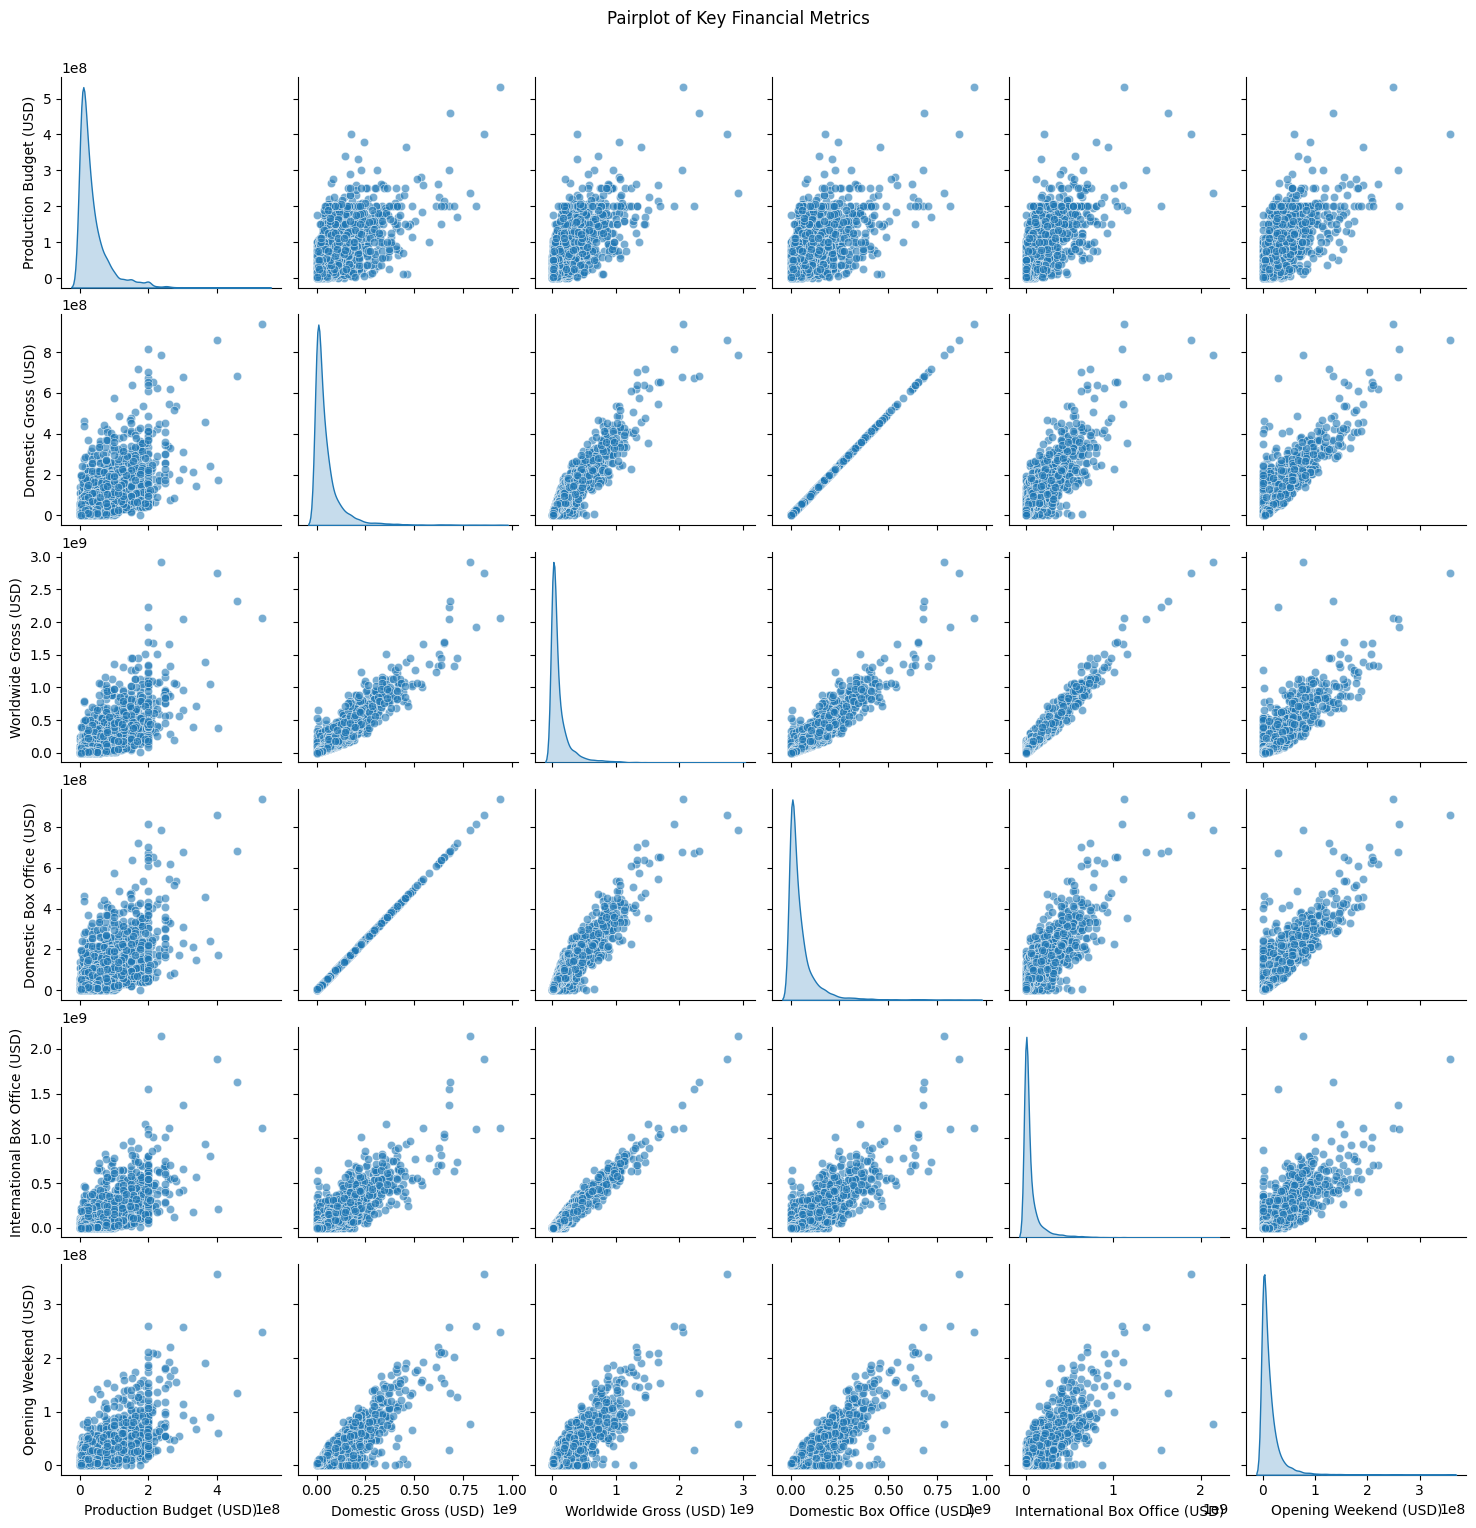

In [35]:
# -------------------------------
# 3. Pairplot：key financial indicators
financial_cols = [
    "Production Budget (USD)", 
    "Domestic Gross (USD)", 
    "Worldwide Gross (USD)",
    "Domestic Box Office (USD)",
    "International Box Office (USD)",
    "Opening Weekend (USD)"
]
sns.pairplot(df[financial_cols].dropna(), diag_kind="kde", plot_kws={"alpha":0.6})
plt.suptitle("Pairplot of Key Financial Metrics", y=1.02)
plt.show()

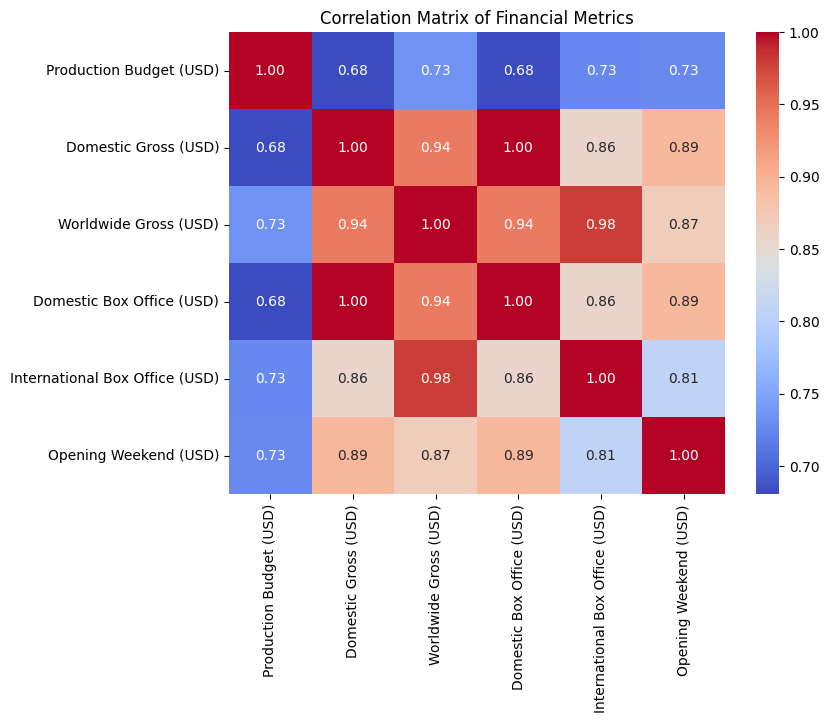

In [36]:
# 4. Correlation heat map: correlation between key financial indicators
corr_matrix = df[financial_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Financial Metrics")
plt.show()

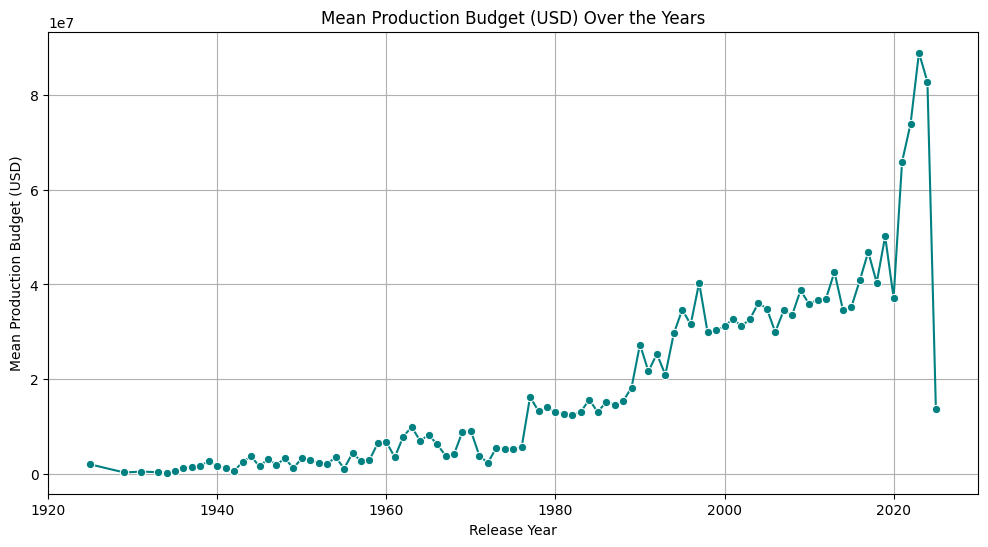

In [37]:
# -------------------------------
#Time-series plot: trends in average Production Budget by year
df_budget_yearly = df.groupby("Release_Year")["Production Budget (USD)"].mean().dropna()
plt.figure(figsize=(12,6))
sns.lineplot(x=df_budget_yearly.index, y=df_budget_yearly.values, marker="o", color="teal")
plt.xlabel("Release Year")
plt.ylabel("Mean Production Budget (USD)")
plt.title("Mean Production Budget (USD) Over the Years")
plt.grid(True)
plt.show()